# Visualize result

In [1]:
import matplotlib.pyplot as plt 
import os.path as osp
from dataset.ReferDataset import ReferDataset
import torch 
import config 
from model.LVAT import LVAT
from PIL import Image
from dataset.transform import get_transform
class Config(object):
    def __init__(self):
        self.type='val'
        self.refer_data_root='./data'
        self.dataset='refcoco'
        self.splitBy='unc'
        self.size=384
        self.bert_tokenizer='bert-base-uncased'

args=Config()
dataset=ReferDataset(args,
                           split=args.type,
                           image_transforms=get_transform(args),
                           eval_mode=False)



In [2]:
import random
random.seed(2021)
refer=dataset.refer
index=random.randint(0,len(dataset.ref_ids))
ref_id=dataset.ref_ids[index]
ref=refer.loadRefs(ref_id)[0]
image=refer.Imgs[refer.getImgIds(ref_id)[0]]

(427, 640, 3)


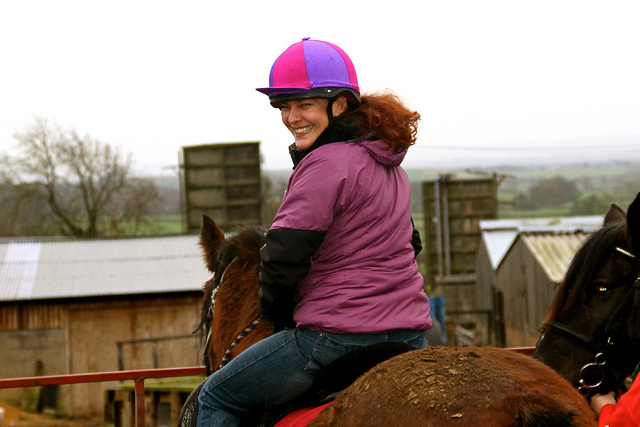

In [3]:
import os.path as osp
import numpy as np 
image_path=osp.join(refer.IMAGE_DIR,image['file_name'])
im=Image.open(image_path)
print(np.array(im).shape)
im

1. black item lower right
2. horse right
box=seg


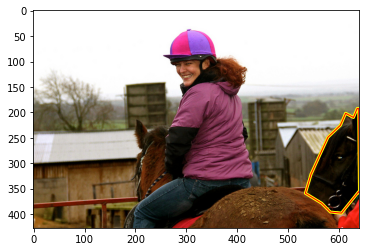

In [4]:
refer.showRef(ref, seg_box='seg')

In [5]:
import torch
from PIL import Image
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from collections import defaultdict
import torch.nn.functional as F
import numpy as np
from skimage.measure import find_contours

from matplotlib import patches,  lines
from matplotlib.patches import Polygon

torch.set_grad_enabled(False)

In [6]:
torch.cuda.set_device(7)
print(f"number of GPUs:{torch.cuda.device_count()}")
print(f"current device:{torch.cuda.current_device()}")

number of GPUs:8
current device:7


In [7]:


# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]


def apply_mask(image,mask,color,alpha=0.5):
    """Apply the given mask to the image
    """
    for c in range(3):
        image[:,:,c]=np.where(mask==1,
                              image[:, :, c] *(1 - alpha) + alpha * color[c] * 255,
                              image[:, :, c])
    return image

def plot_results(pil_img,mask):
    plt.figure(figsize=(16,10))
    np_image = np.array(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    c=colors[0]
    np_image=apply_mask(np_image,mask,c)
    padded_mask = np.zeros((mask.shape[0] + 2, mask.shape[1] + 2), dtype=np.uint8)
    padded_mask[1:-1, 1:-1] = mask
    contours = find_contours(padded_mask, 0.5)
    for verts in contours:
        # Subtract the padding and flip (y, x) to (x, y)
        verts = np.fliplr(verts) - 1
        p = Polygon(verts, facecolor="none", edgecolor=c)
        ax.add_patch(p)
    
    plt.imshow(np_image)
    plt.axis('off')
    plt.show()



In [8]:
# bulid model
import config
model=LVAT(config)
model.cuda()
checkpoint=torch.load('checkpoint/ckpt_epoch_10.pth',map_location='cpu')
model.load_state_dict(checkpoint['model'],strict=False)
model.eval()
img,_,emb,att_mask=dataset[index]
img=img.unsqueeze(0)
img,emb,att_mask=img.cuda(),emb.cuda(),att_mask.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/home/ZhangZicheng/anaconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required 

In [9]:
import torch.nn.functional as F
def plot_inference():
    output=model(img,emb,att_mask) # [1,2,H,W]
    np_img=np.array(im)
    ori_H,ori_W,_=np_img.shape
    output=F.interpolate(output,size=[ori_H,ori_W],mode='bilinear')
    pred=output.argmax(1) #[1,ori_H,ori_W]
    pred=pred.cpu().numpy()
    pred=pred.squeeze(0)

    plot_results(im,pred)

/home/ZhangZicheng/anaconda3/lib/python3.9/site-packages/torch/nn/functional.py:3631: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


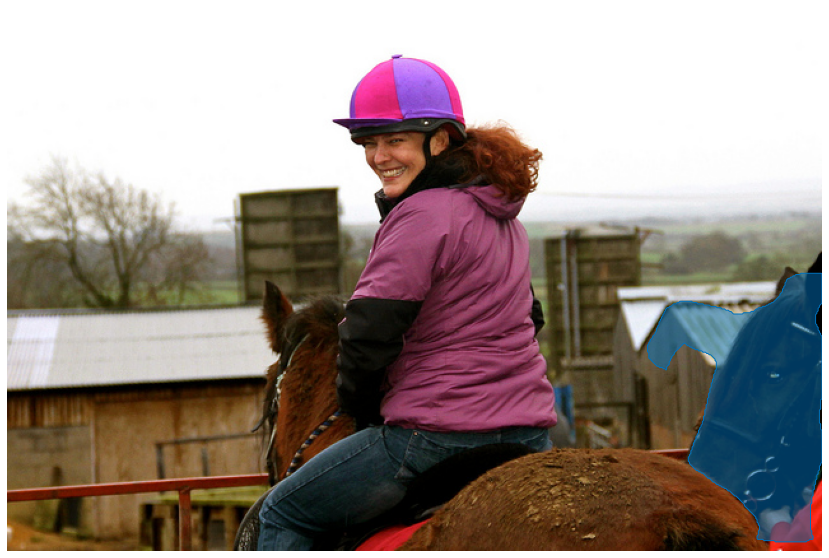

In [10]:
plot_inference()

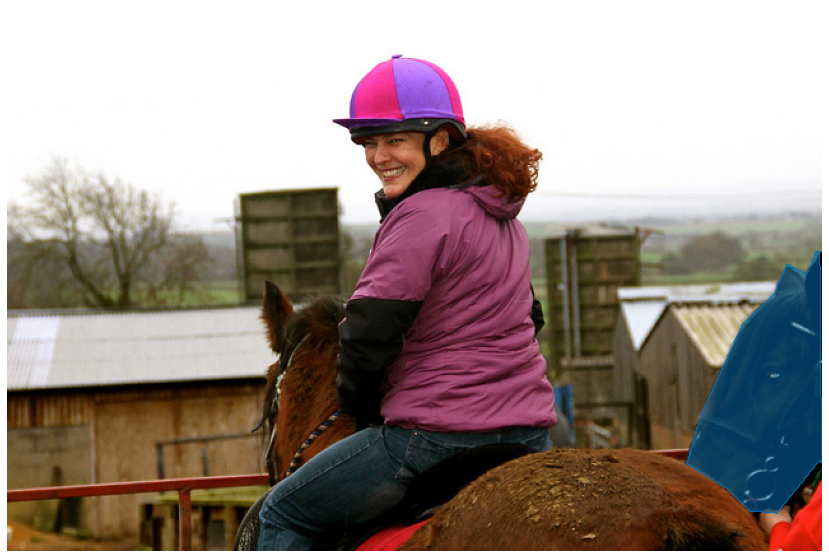

In [11]:
# plot ground truth
gt_mask=refer.getMask(ref)['mask']
plot_results(im,gt_mask)